In [1]:
import qiskit
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.quantum_info import partial_trace, state_fidelity
import matplotlib.pyplot as plt

aer_sim = Aer.get_backend('aer_simulator')
statevector_sim = Aer.get_backend('statevector_simulator')

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.21.1', 'qiskit-aer': '0.10.4', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.37.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

### Program to simulate pseudo-threshold of 3-qubit repetition code under i.i.d. bit flip noise on data qubits and using a naive lookup-table syndrome decoder.

#### Program: Construct a 3-qubit repetition code circuit. Inject bit flip errors on data qubits probabilistically (i.i.d.). Vary the error rate, apply corrections based on syndrome, and count how many instances lead to a logical error (i.e. a Monte-Carlo simulation).

In [45]:
# Physical error rate
p_phys = np.arange(0,1,0.01)

verbose = False

logical_error_counts = [None]*len(p_phys)

rounds = 1000

for j in range(len(p_phys)):
    
    # This print is just to check if the simulation is progressing
    print("Simulating for p_phys = ", p_phys[j])

    logical_error_counts[j] = 0
    
    # Error correction rounds
    # Right now, for every round, the circuit gets created and initialized anew
    for i in range(rounds):
        
        data_qubits = QuantumRegister(3, 'data_qubits')
        anc_qubits = QuantumRegister(2, 'anc_qubits')
        syndrome_bits = ClassicalRegister(2, 'syndrome_bits')
        rep_code_3 = QuantumCircuit(data_qubits, anc_qubits, syndrome_bits)

        # Right now, initial state is |0>. Could run for different initial states.
        # rep_code_3.rx(np.pi/3, 0)

        rep_code_3.barrier()

        rep_code_3.cx(data_qubits[0],data_qubits[1])
        rep_code_3.cx(data_qubits[0],data_qubits[2])

        # Extract ideal initial state to compare (later) with the obtained state 
        # to decide whether there was a decoding error or not
        #
        # This can be replaced if initial state vector is known exactly.
        result = execute(rep_code_3, statevector_sim).result()
        state_qec = result.get_statevector(rep_code_3)
        ideal_initial_state = partial_trace(state_qec, [3,4])

        rep_code_3.barrier()
        
        # Injecting a Pauli X error stochastically. A full Pauli error is applied
        # to any of the data qubits with some probability and independently.
        
        # In PJ Derks' thesis, code capacity error model is defined as error happening 
        # on data qubits with same probability on each qubit and before the syndrome
        # extraction circuit. Ancillas are assumed to never get affected by an error,
        # there is no idling error, no measurement error etc.
        #
        # Going by this definition, the error model implemented below should be the 
        # same as code capacity model (I suppose).
        for n in range(3):
            if(np.random.uniform() < p_phys[j]):
                rep_code_3.x(data_qubits[n])
                if(verbose):
                    print("Injecting X error on qubit", n)

        rep_code_3.barrier()

        # Parity measurements
        rep_code_3.cx(data_qubits[0], anc_qubits[0])
        rep_code_3.cx(data_qubits[1], anc_qubits[0])

        rep_code_3.cx(data_qubits[1], anc_qubits[1])
        rep_code_3.cx(data_qubits[2], anc_qubits[1])

        rep_code_3.barrier()

        rep_code_3.measure(anc_qubits, syndrome_bits)

        rep_code_3.barrier()

        # Measure ancilla to get syndrome.
        result = execute(rep_code_3, aer_sim, shots=1).result()
        counts = result.get_counts(rep_code_3)
        if(verbose):
            print(counts)

        syndrome = list(counts.keys())
        if(verbose):
            print("Syndrome = ", syndrome)

    #     # Sanity check
    #     # When we know which error has been injected, we can compare
    #     # the theoretically expected syndrome with the one obtained here
    #     assert(
    #         ((error_qubit == 0) and (syndrome == ['01'])) or 
    #         ((error_qubit == 1) and (syndrome == ['11'])) or
    #         ((error_qubit == 2) and (syndrome == ['10']))
    #     )

        # "Lookup table" for decoding and correction: Dictionary implementation
        # Contains the qubit index on which the correction is to be applied
        syndrome_lookup_table = {'00': None, '01': 0, '10': 2, '11': 1}
        
        correction_qubit = syndrome_lookup_table[syndrome[0]]
        if(correction_qubit is not None):
            if(verbose):
                print("Applying X correction on qubit", correction_qubit)
            rep_code_3.x(correction_qubit)
        else:
            if(verbose):
                print("Applying no correction")
        
        # For now, the ancilla are not being reset after syndrome decoding
        
        rep_code_3.barrier()
        
        # Simulate statevector to determine if there has been a decoding error
        result = execute(rep_code_3, statevector_sim).result()
        state_qec = result.get_statevector(rep_code_3)
        current_state = partial_trace(state_qec, [3,4])
        
        assert np.isclose(current_state.purity(), 1), "State of data qubits after ancilla have been measured must not be a mixed state (in this case)"

        # If state of data qubits is not close enough to the expected (encoded) state,
        # count it as a logical error
        if(not np.isclose(state_fidelity(current_state, ideal_initial_state), 1.0)):
            logical_error_counts[j] += 1

logical_error_probs = [logical_error_count/rounds for logical_error_count in logical_error_counts]
print("logical_error_counts = ", logical_error_counts)
print("logical_error_probs = ", logical_error_probs)

Simulating for p_phys =  0.0
Simulating for p_phys =  0.01
Simulating for p_phys =  0.02
Simulating for p_phys =  0.03
Simulating for p_phys =  0.04
Simulating for p_phys =  0.05
Simulating for p_phys =  0.06
Simulating for p_phys =  0.07
Simulating for p_phys =  0.08
Simulating for p_phys =  0.09
Simulating for p_phys =  0.1
Simulating for p_phys =  0.11
Simulating for p_phys =  0.12
Simulating for p_phys =  0.13
Simulating for p_phys =  0.14
Simulating for p_phys =  0.15
Simulating for p_phys =  0.16
Simulating for p_phys =  0.17
Simulating for p_phys =  0.18
Simulating for p_phys =  0.19
Simulating for p_phys =  0.2
Simulating for p_phys =  0.21
Simulating for p_phys =  0.22
Simulating for p_phys =  0.23
Simulating for p_phys =  0.24
Simulating for p_phys =  0.25
Simulating for p_phys =  0.26
Simulating for p_phys =  0.27
Simulating for p_phys =  0.28
Simulating for p_phys =  0.29
Simulating for p_phys =  0.3
Simulating for p_phys =  0.31
Simulating for p_phys =  0.32
Simulating for

#### Plot the probability of logical error vs physical error rate, and compare it with the bound expected from theory.

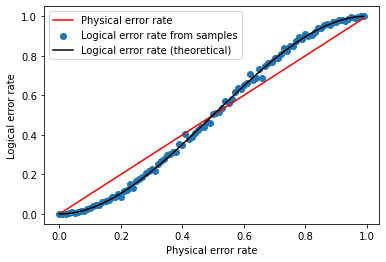

In [46]:
plt.plot(p_phys, p_phys, 'r')
plt.scatter(p_phys, logical_error_probs)
plt.plot(p_phys, (3*p_phys*p_phys) - (2*p_phys*p_phys*p_phys), 'black')

plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')

plt.legend(['Physical error rate','Logical error rate from samples','Logical error rate (theoretical)'])

plt.show()